In [1]:
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for plotting

from sklearn.model_selection import train_test_split  # for splitting dataset
from sklearn.preprocessing import StandardScaler, label_binarize  # normalization and label encoding
from sklearn.decomposition import PCA  # for dimensionality reduction
from sklearn.linear_model import LogisticRegression  # classifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay  # evaluation
from sklearn.multiclass import OneVsRestClassifier  # for multi-class classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10  # CIFAR-10 dataset
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from skimage.color import rgb2gray  # for grayscale conversion


## Task 01

 Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
X_rgb = np.concatenate((x_train, x_test)).astype("float32") / 255.0
y = np.concatenate((y_train, y_test)).flatten()

# Convert to grayscale
X_gray = np.array([rgb2gray(img) for img in X_rgb])  # shape (60000, 32, 32)

# For PCA or FC autoencoders
X_flat = X_gray.reshape((X_gray.shape[0], -1))  # shape (60000, 1024)

X_gray_cnn = np.expand_dims(X_gray, axis=-1)
X_gray_cnn.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


(60000, 32, 32, 1)

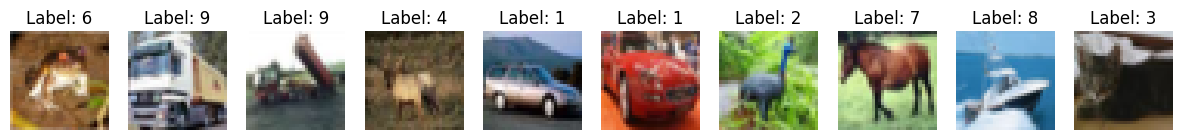

In [3]:
def show_images(images, labels=None, num=5, cmap=None, figsize=(15, 3)):
	plt.figure(figsize=figsize)
	for i in range(num):
					plt.subplot(1, num, i+1)
					if images.ndim == 4:  # e.g. (N, H, W, 3) or (N, H, W, 1)
									img = images[i]
									# if single channel, squeeze to 2D for imshow
									if img.shape[-1] == 1:
													img = img.squeeze(-1)
									plt.imshow(img, cmap=cmap)
					elif images.ndim == 3:  # e.g. (N, H, W)
									plt.imshow(images[i], cmap=cmap)
					else:
									raise ValueError("Unsupported image array shape")

					if labels is not None:
									plt.title(f"Label: {labels[i]}")
					plt.axis('off')
	plt.show()

show_images(x_train, labels=y_train.flatten(), num=10, cmap='gray')

In [4]:
X_flat

array([[0.24091999, 0.17760941, 0.18848823, ..., 0.73579454, 0.4806318 ,
        0.38096273],
       [0.6777784 , 0.5278055 , 0.40613174, ..., 0.53159845, 0.53525215,
        0.53301215],
       [0.99999994, 0.99215686, 0.99215686, ..., 0.32693452, 0.32776785,
        0.33168942],
       ...,
       [0.06214196, 0.05822039, 0.05488706, ..., 0.09866353, 0.10117843,
        0.09023216],
       [0.13644588, 0.11434589, 0.13928118, ..., 0.44800037, 0.4471443 ,
        0.4359451 ],
       [0.30086744, 0.40258238, 0.4121149 , ..., 0.44587606, 0.25542274,
        0.10279412]], dtype=float32)

In [5]:
# 🎯 Split into train and test sets: 70% training, 30% test

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y)

# 🧪 From training set, extract 70% subset to use for PCA training only
X_pca_train, _, _, _ = train_test_split(
    X_train, y_train, train_size=0.7, random_state=42, stratify=y_train)

# 🧼 Normalize (zero mean, unit variance)
scaler = StandardScaler()
X_pca_train = scaler.fit_transform(X_pca_train)       # fit only on PCA training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔁 Convert class labels to one-hot encoding (required for ROC)
y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))


In [6]:
def run_pca_and_classify(X_pca_train, X_train, y_train_bin, X_test, y_test_bin, method='standard'):
    """
    Perform PCA (standard or randomized), train logistic regression, and compute ROC curves.
    Returns: fpr, tpr, auc_dict, trained_pca_object
    """
    if method == 'standard':
        pca = PCA(n_components=0.95, svd_solver='full')
        pca.fit(X_pca_train)
    else:
        tmp_pca = PCA(n_components=0.95, svd_solver='full')
        tmp_pca.fit(X_pca_train)
        n_components_95 = tmp_pca.n_components_
        pca = PCA(n_components=n_components_95, svd_solver='randomized', random_state=42)
        pca.fit(X_pca_train)

    X_train_proj = pca.transform(X_train)
    X_test_proj = pca.transform(X_test)

    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(X_train_proj, y_train_bin)
    y_score = clf.decision_function(X_test_proj)

    fpr, tpr, auc_dict = {}, {}, {}
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_dict[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, auc_dict, pca


In [7]:
fpr_std, tpr_std, auc_std, pca_std = run_pca_and_classify(
    X_pca_train, X_train_scaled, y_train_bin, X_test_scaled, y_test_bin, 'standard')


In [8]:
fpr_rand, tpr_rand, auc_rand, pca_rand = run_pca_and_classify(
    X_pca_train, X_train_scaled, y_train_bin, X_test_scaled, y_test_bin, 'randomized')


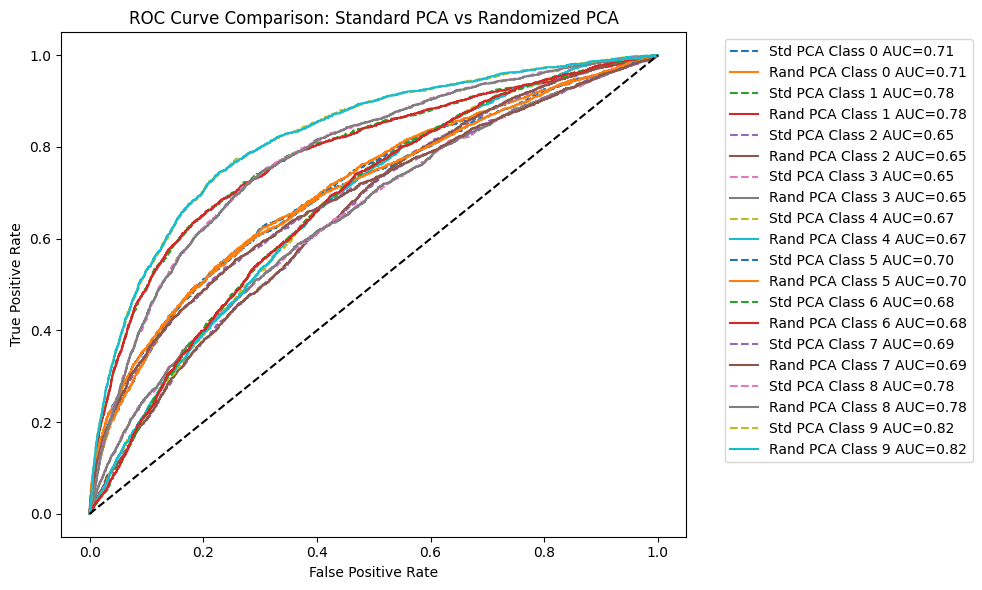

In [9]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(fpr_std[i], tpr_std[i], '--', label=f'Std PCA Class {i} AUC={auc_std[i]:.2f}')
    plt.plot(fpr_rand[i], tpr_rand[i], '-', label=f'Rand PCA Class {i} AUC={auc_rand[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.title('ROC Curve Comparison: Standard PCA vs Randomized PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Comparision
| Class | Std PCA AUC | Rand PCA AUC | Interpretation                              |
| ----- | ----------- | ------------ | ------------------------------------------- |
| 0     | 0.71        | 0.71         | Equal performance                           |
| 1     | 0.78        | 0.78         | Both methods capture this class well        |
| 2     | 0.65        | 0.65         | Poor performance for both (difficult class) |
| 3     | 0.65        | 0.65         | Same; possibly hard to distinguish visually |
| 4     | 0.67        | 0.67         | Slightly better but still weak              |
| 5     | 0.70        | 0.71         | Almost equal                                |
| 6     | 0.68        | 0.68         | Consistent performance                      |
| 7     | 0.69        | 0.69         | Identical performance                       |
| 8     | 0.78        | 0.78         | Good, consistent                            |
| 9     | 0.82        | 0.82         | Best-performing class for both              |


- Randomized PCA achieves performance nearly identical to Standard PCA, with matching ROC curves and AUC scores across all classes.
-  Given its speed advantage and scalability, Randomized PCA is a practical choice for dimensionality reduction in large image datasets like CIFAR-10.

## Task 02

Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other and each weight vector has unit magnitude. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders by displaying the eigenvectors in Task 1 and weight matrix obtained in Task 2 as gray scale images. Comment on these images.

In [10]:
# Mean and variance normalized input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9117 - val_loss: 0.9136
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9080 - val_loss: 0.9136
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9078 - val_loss: 0.9136
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9131 - val_loss: 0.9136
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9112 - val_loss: 0.9136
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9126 - val_loss: 0.9136
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9105 - val_loss: 0.9136
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9050 - val_loss: 0.9136
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9078 - val_loss: 0.9136
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9104 - val_loss: 0.9136
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9104 - val_loss: 0.9136
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0

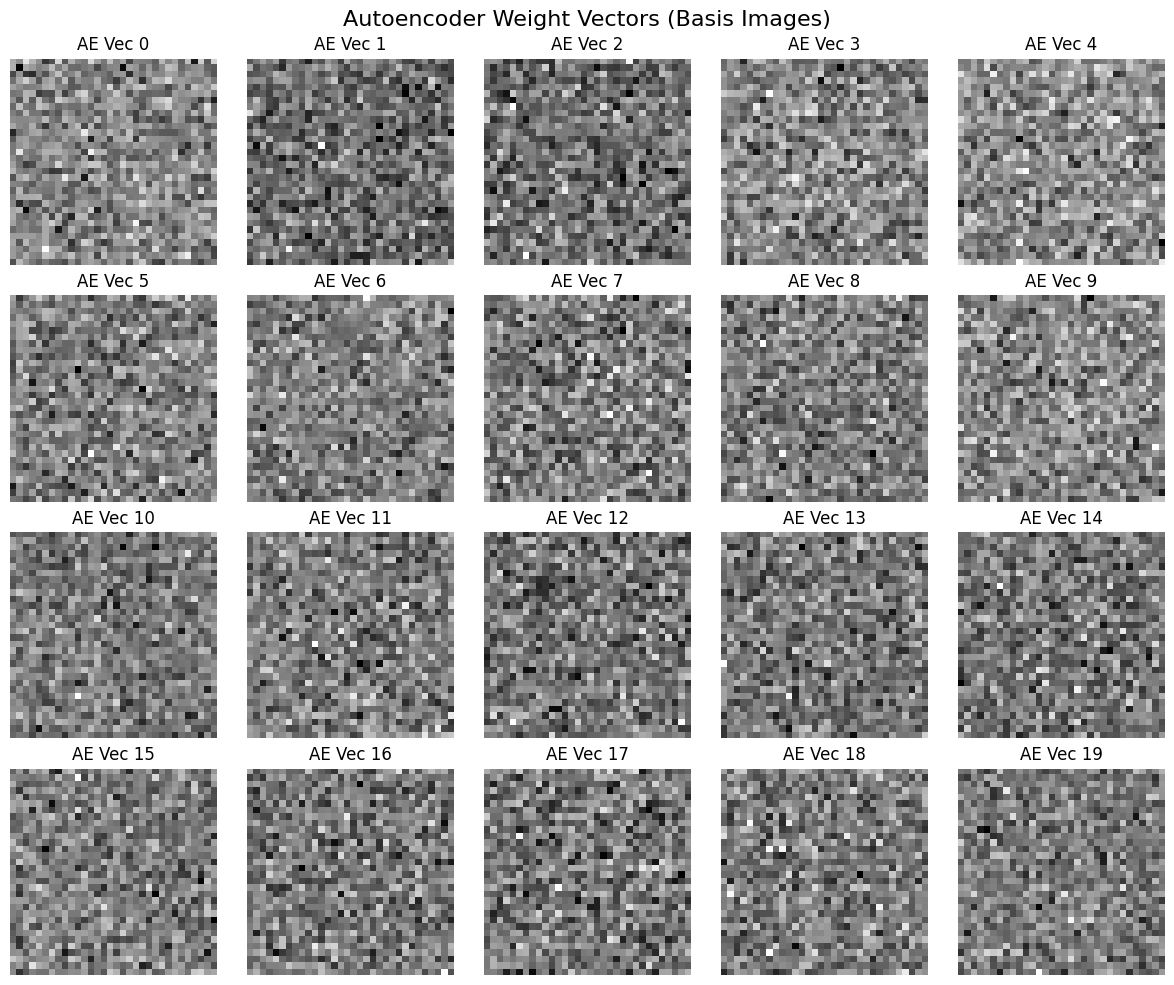

In [11]:
# Step 2: Define tied-weight linear autoencoder
input_dim = X_train_scaled.shape[1]
encoding_dim = 100  # Use same as PCA

# Manual weight variable with unit norm enforced
W = tf.Variable(tf.random.normal([input_dim, encoding_dim]), name="W")

def encoder_layer(x):
    W_norm = tf.linalg.l2_normalize(W, axis=0)  # unit-norm columns
    return tf.matmul(x, W_norm)

def decoder_layer(z):
    W_norm = tf.linalg.l2_normalize(W, axis=0)
    return tf.matmul(z, tf.transpose(W_norm))

input_img = Input(shape=(input_dim,))

#Single-layer autoencoder with linear activation
encoded = Lambda(encoder_layer)(input_img)
decoded = Lambda(decoder_layer)(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(0.01), loss='mse')

# Step 3: Train
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                verbose=1)

# Step 4: Extract learned weights (normalized)
W_learned = tf.linalg.l2_normalize(W, axis=0).numpy()  # shape (1024, 100)

# Step 5: Visualize first 20 components as grayscale 32x32
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(W_learned[:, i].reshape(32, 32), cmap='gray')
    ax.set_title(f"AE Vec {i}")
    ax.axis('off')
plt.suptitle("Autoencoder Weight Vectors (Basis Images)", fontsize=16)
plt.tight_layout()
plt.show()

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9080 - val_loss: 0.9136
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9044 - val_loss: 0.9136
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9072 - val_loss: 0.9136
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9122 - val_loss: 0.9136
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9057 - val_loss: 0.9136
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9055 - val_loss: 0.9136
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9118 - val_loss: 0.9136
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9098 - val_loss: 0.9136
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9087 - val_loss: 0.9136
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9093 - val_loss: 0.9136
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9075 - val_loss: 0.9136
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

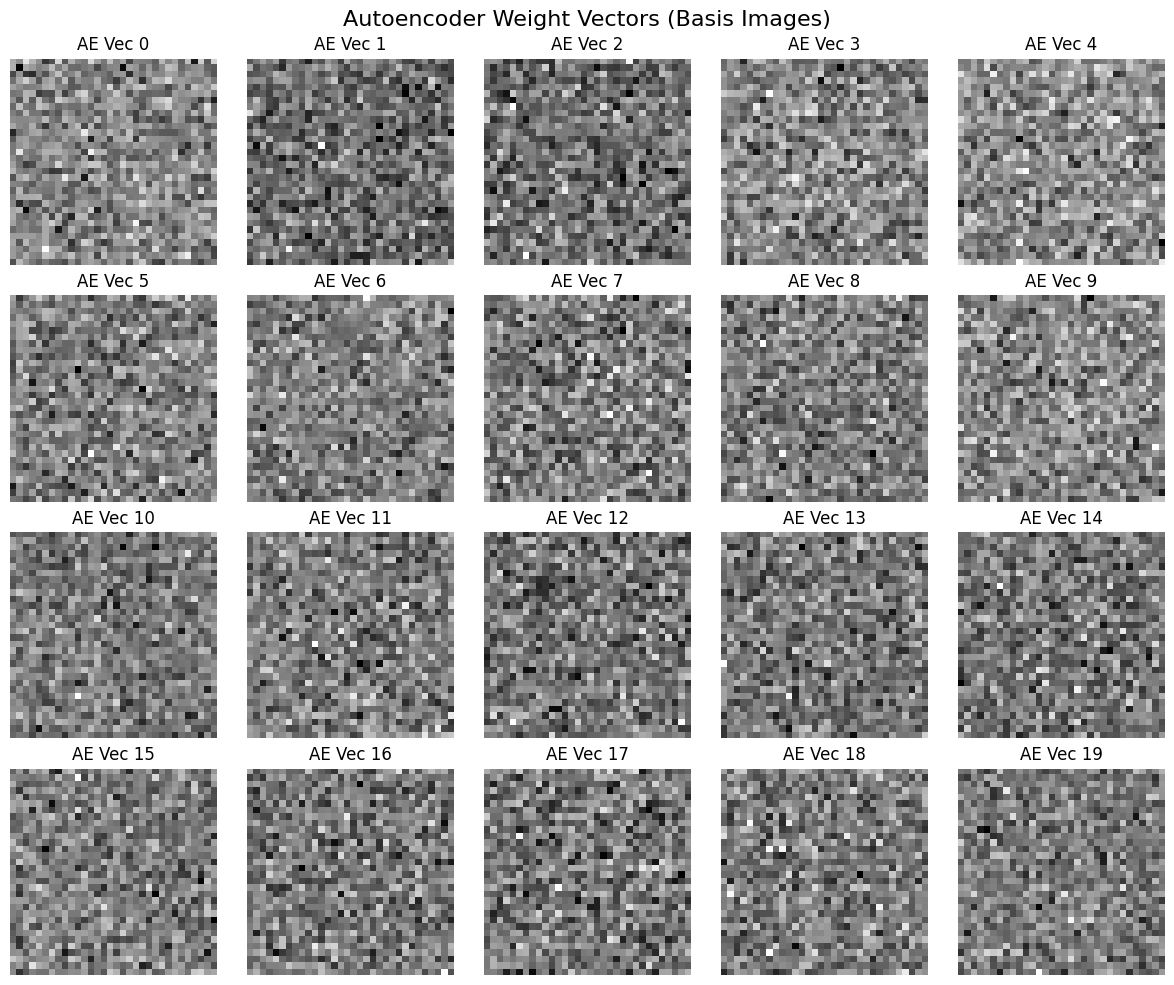

In [12]:
# Step 3: Train
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                verbose=1)

# Step 4: Extract learned weights (normalized)
W_learned = tf.linalg.l2_normalize(W, axis=0).numpy()  # shape (1024, 100)

# Step 5: Visualize first 20 components as grayscale 32x32
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(W_learned[:, i].reshape(32, 32), cmap='gray')
    ax.set_title(f"AE Vec {i}")
    ax.axis('off')
plt.suptitle("Autoencoder Weight Vectors (Basis Images)", fontsize=16)
plt.tight_layout()
plt.show()

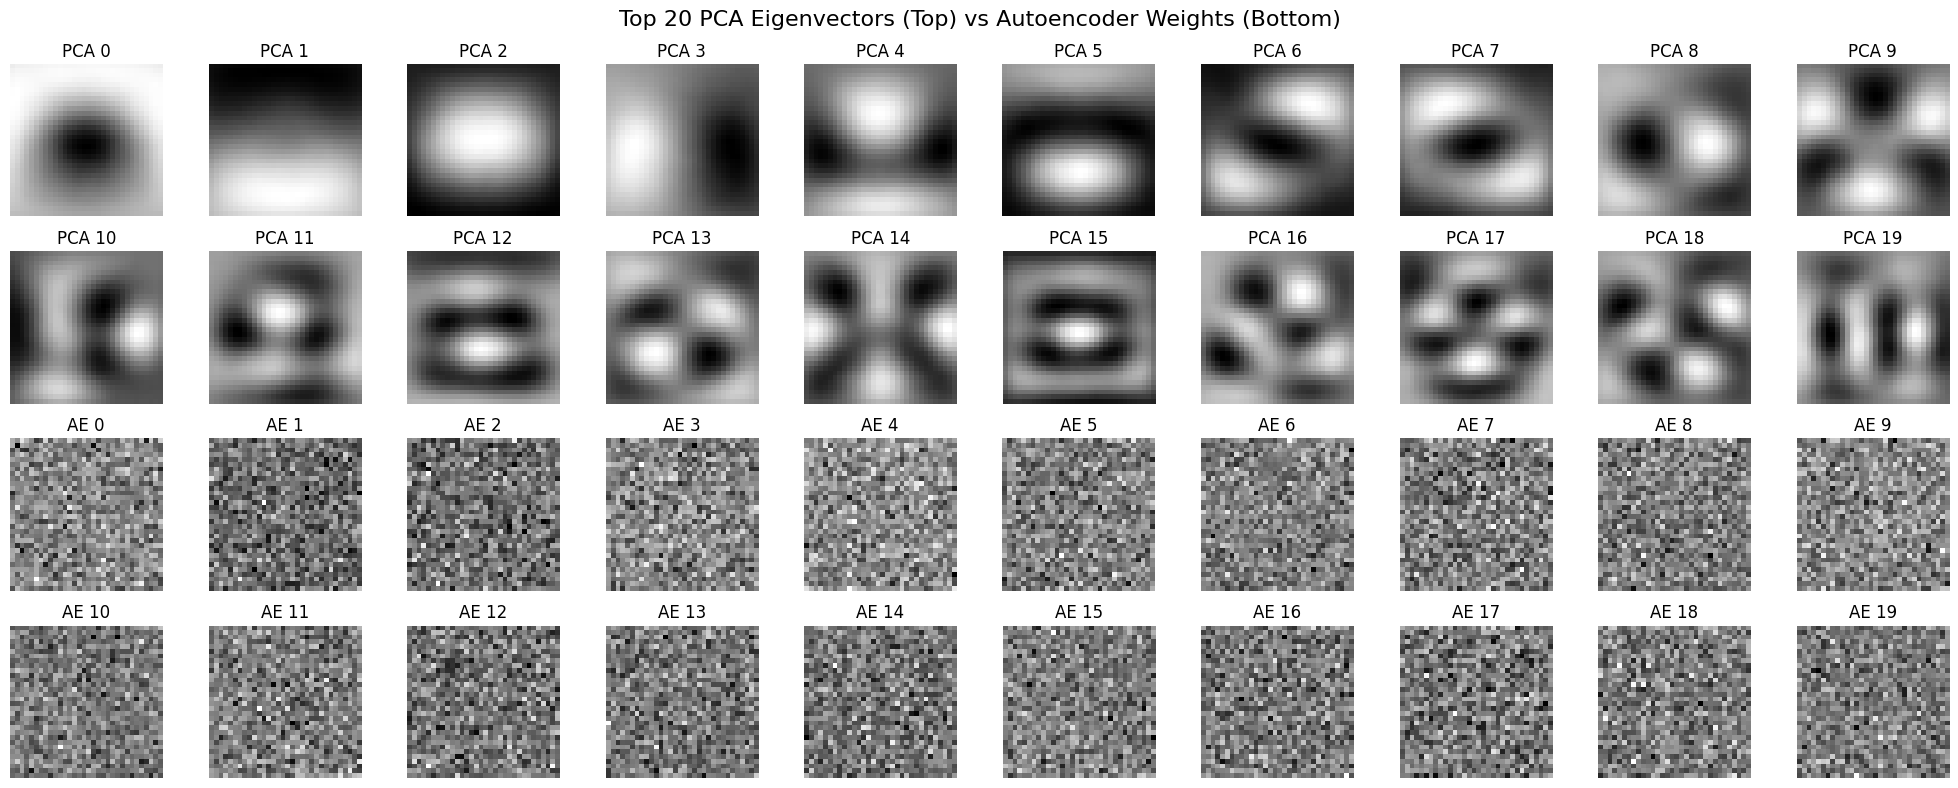

In [13]:
# Plot PCA vs AE weights side-by-side
fig, axs = plt.subplots(4, 10, figsize=(20, 8))
for i in range(20):
    axs[i//10, i%10].imshow(pca_std.components_[i].reshape(32, 32), cmap='gray')
    axs[i//10, i%10].set_title(f'PCA {i}')
    axs[i//10, i%10].axis('off')

    axs[(i//10)+2, i%10].imshow(W_learned[:, i].reshape(32, 32), cmap='gray')
    axs[(i//10)+2, i%10].set_title(f'AE {i}')
    axs[(i//10)+2, i%10].axis('off')

plt.suptitle("Top 20 PCA Eigenvectors (Top) vs Autoencoder Weights (Bottom)", fontsize=16)
plt.tight_layout()
plt.show()


## Comments on images.

The top row of images, representing the top 20 PCA eigenvectors, clearly shows structured patterns such as horizontal and vertical gradients, edge detectors, and blob-like features. These patterns capture the primary modes of variation in the grayscale CIFAR-10 dataset and are typical of what PCA extracts as principal components.

In contrast, the bottom row, representing the encoder weight vectors learned by the linear autoencoder, lacks clear spatial patterns. The filters appear noisy and unstructured, indicating that the autoencoder has not successfully captured the dominant data structure.

This discrepancy suggests that, despite enforcing linear activation, tied weights, and unit norm constraints, the autoencoder may have failed to converge to the optimal solution comparable to PCA. Possible reasons include:

- The initialization of the weight matrix may have led to poor local minima.

- The optimizer and number of epochs may not have been sufficient.

- The autoencoder lacks orthogonality constraints (unlike PCA), which may result in redundant or uninformative filters.

# Task 3

In [14]:
N = pca_std.n_components_
N

np.int64(162)

In [15]:

input_img = layers.Input(shape=(32, 32, 1))

# Encoder
x = layers.Conv2D(32, (3, 3),  padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8
#x = layers.Conv2D(128, (3, 3),  padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
#x=layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
x = tf.keras.layers.Flatten()(x)
#encoded = layers.Conv2D(N, (3, 3), activation='relu', padding='same')(x)  #
encoded = Dense(N, activation='relu')(x)
# Decoder
x = Dense(8*8*64, activation='relu')(encoded)
x = tf.keras.layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)



# Build model
conv_autoencoder  = models.Model(input_img, decoded)
conv_autoencoder .compile(optimizer='adam', loss='mse')


In [16]:
input_layer = Input(shape=(1024,))
latent_dim = N
# Encoder: single hidden layer with sigmoid activation
encoded = layers.Dense(latent_dim, activation='sigmoid')(input_layer)

# Decoder: linear activation (no activation)
decoded = layers.Dense(1024, activation='linear')(encoded)

# Reshape back to image shape
#decoded_img = layers.Reshape((32, 32, 1))(decoded)

fc_autoencoder = models.Model(input_img, decoded)
fc_autoencoder.compile(optimizer='adam', loss='mse')


In [18]:
total_hidden_nodes = N
nodes_per_layer = total_hidden_nodes // 3  # integer division

input_img = layers.Input(shape=(1024,))

# Encoder: 3 hidden layers with sigmoid activation
x = layers.Dense(nodes_per_layer, activation='sigmoid')(input_img)
x = layers.Dense(nodes_per_layer, activation='sigmoid')(x)
encoded = layers.Dense(nodes_per_layer, activation='sigmoid')(x)

# Decoder: mirror the encoder
x = layers.Dense(nodes_per_layer, activation='sigmoid')(encoded)
x = layers.Dense(nodes_per_layer, activation='sigmoid')(x)
decoded = layers.Dense(1024, activation='linear')(x)


fc3_autoencoder = models.Model(input_img, decoded)
fc3_autoencoder.compile(optimizer='adam', loss='mse')


In [19]:
conv_autoencoder.summary()
fc_autoencoder.summary()
fc3_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 162)            │       663,714 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       667,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,406,243 (5.36 MB)

 Trainable params: 1,406,051 (5.36 MB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 162)       │    166,050 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │    166,912 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,962 (1.27 MB)

 Trainable params: 332,962 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 54)             │        55,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │        56,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,550 (482.62 KB)

 Trainable params: 123,550 (482.62 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:

X_train_gray_cnn, X_test_gray_cnn, y_train_split, y_test_split = train_test_split(
    X_gray_cnn, y, test_size=0.3, stratify=y, random_state=42)


In [24]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train convolutional autoencoder
conv_autoencoder.fit(
    X_train_gray_cnn, X_train_gray_cnn,
    epochs=1,
    batch_size=128,
    validation_data=(X_test_gray_cnn, X_test_gray_cnn),
    callbacks=[early_stop]
)
X_train_flat, X_test_flat, _, _ = train_test_split(
    X_flat, y, test_size=0.3, stratify=y, random_state=42)
scaler_fc = StandardScaler()
X_train_flat_scaled = scaler_fc.fit_transform(X_train_flat)
X_test_flat_scaled = scaler_fc.transform(X_test_flat)


# Train fully connected autoencoder
fc_autoencoder.fit(
    X_train_flat_scaled, X_train_flat,
    epochs=1,
    batch_size=128,
    validation_data=(X_test_flat_scaled, X_test_flat),
    callbacks=[early_stop]
)

# Train 3-hidden-layer autoencoder
fc3_autoencoder.fit(
    X_train_flat_scaled, X_train_flat,
    epochs=1,
    batch_size=128,
    validation_data=(X_test_flat_scaled, X_test_flat),
    callbacks=[early_stop]
)


329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0084 - val_loss: 0.0091


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(None, 1024)

In [ ]:
# # Early stopping to prevent overfitting
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train convolutional autoencoder
# conv_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray),callbacks=[early_stop])

# # Train fully connected autoencoder
# fc_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

# # Train fully 3 hidden layer connected autoencoder
# fc3_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

In [ ]:
conv_decoded = conv_autoencoder.predict(X_test_gray_cnn)
fc_decoded = fc_autoencoder.predict(X_test_gray_cnn)
fc3_decoded = fc3_autoencoder.predict(X_test_gray_cnn)

# Compute mean squared error per sample and average
def mse_per_sample(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))

conv_errors = mse_per_sample(X_test_gray_cnn, conv_decoded)
fc_errors = mse_per_sample(X_test_gray_cnn, fc_decoded)
fc3_errors = mse_per_sample(X_test_gray_cnn, fc3_decoded)

# Print the mean reconstruction errors
print("Conv Autoencoder Mean Reconstruction Error:", np.mean(conv_errors))
print("FC Autoencoder Mean Reconstruction Error:", np.mean(fc_errors))
print("FC3 Autoencoder Mean Reconstruction Error:", np.mean(fc3_errors))


563/563 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Conv Autoencoder Mean Reconstruction Error: 0.03433441
FC Autoencoder Mean Reconstruction Error: 0.023913436
FC3 Autoencoder Mean Reconstruction Error: 0.041098393


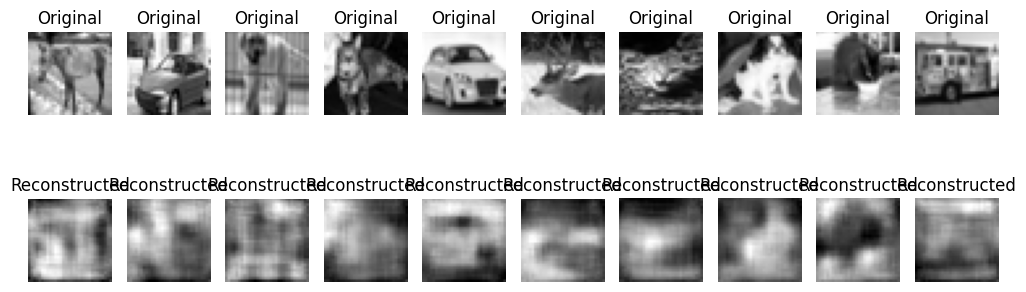

In [ ]:
def show_reconstruction(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call with updated variables
show_reconstruction(X_test_gray_cnn, conv_decoded, n=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


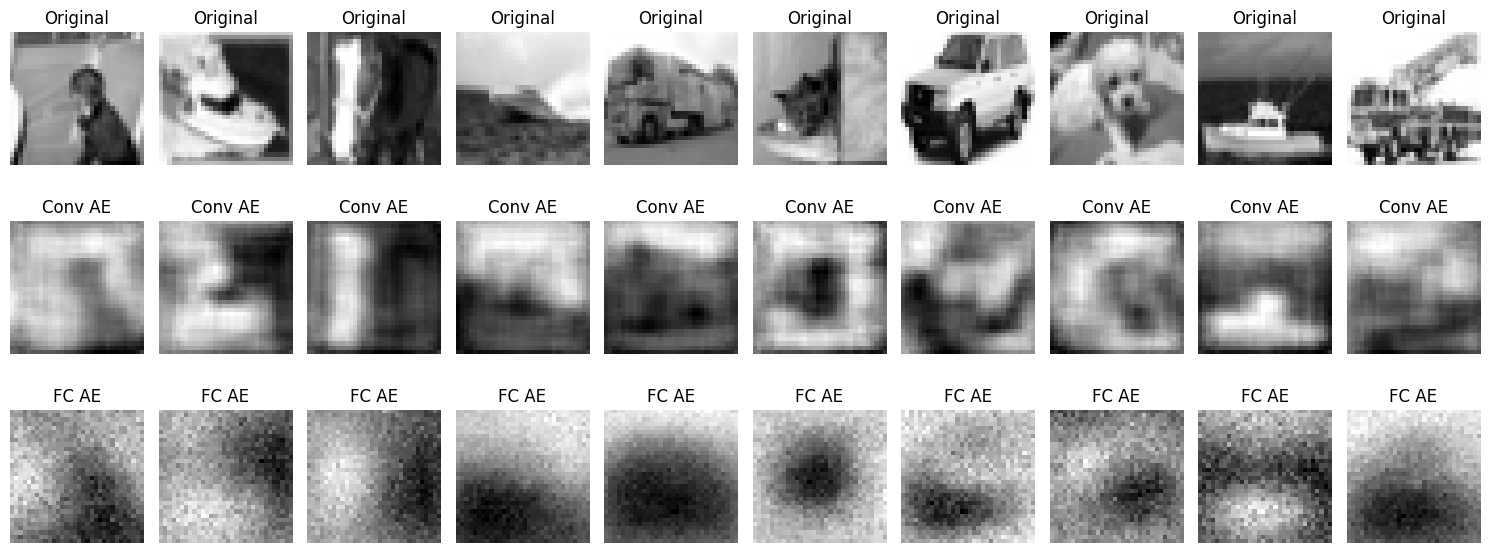

In [ ]:
n = 10
indices = np.random.choice(len(X_test_gray_cnn), n)
test_imgs = X_test_gray_cnn[indices]

# Get reconstructions
recon_cae = conv_autoencoder.predict(test_imgs)
recon_fcae = fc_autoencoder.predict(test_imgs)

# Plotting
plt.figure(figsize=(15, 6))

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(test_imgs[i].squeeze(), cmap='gray')
    ax.set_title("Original")
    ax.axis("off")

    # Conv Autoencoder
    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(recon_cae[i].squeeze(), cmap='gray')
    ax.set_title("Conv AE")
    ax.axis("off")

    # FC Autoencoder
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    ax.imshow(recon_fcae[i].squeeze(), cmap='gray')
    ax.set_title("FC AE")
    ax.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


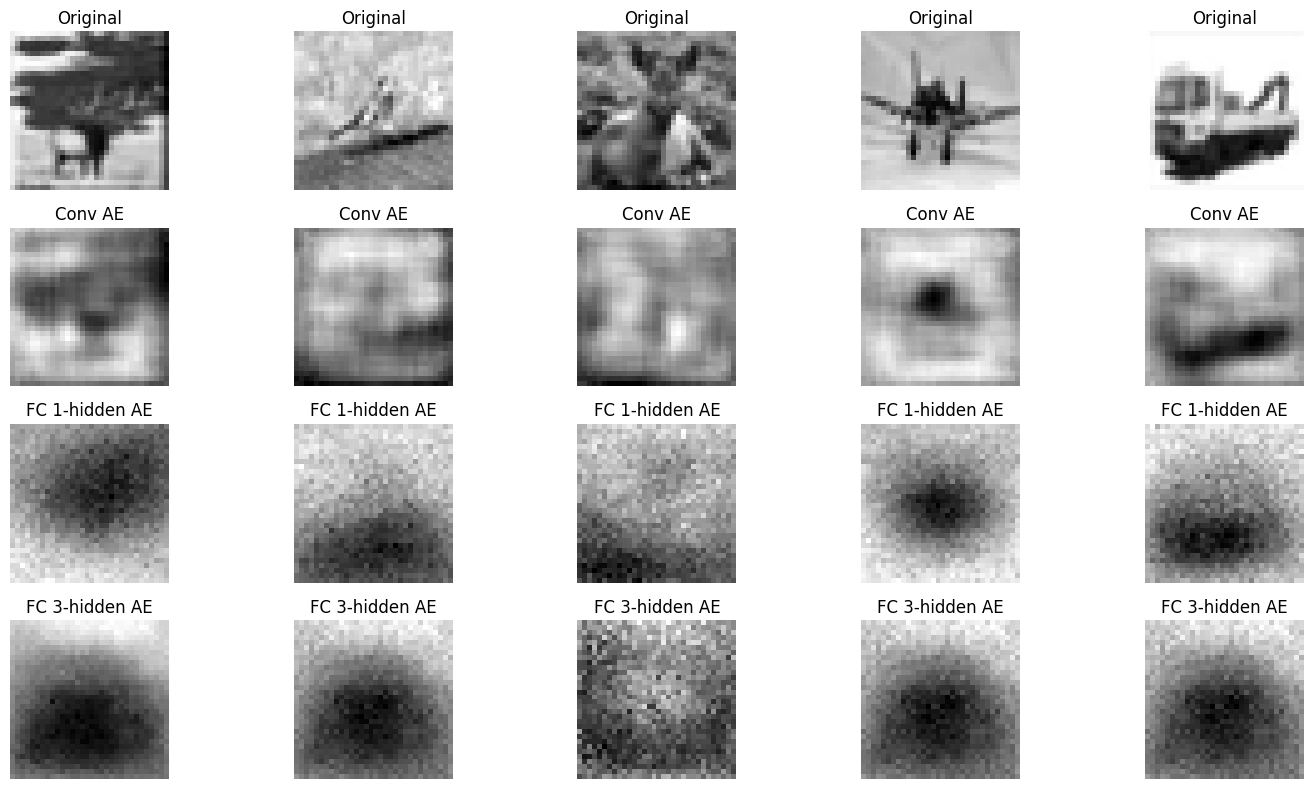

In [ ]:
def plot_reconstructions(orig, reconstructions, model_names, n=5):
    plt.figure(figsize=(15, 8))
    total_rows = len(reconstructions) + 1  # +1 for original
    total_cols = n

    for i in range(n):
        # Original image row (row 0)
        ax = plt.subplot(total_rows, total_cols, i + 1)
        ax.imshow(orig[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        ax.axis('off')

        # Reconstructed images rows (rows 1, 2, ...)
        for j, recon in enumerate(reconstructions):
            ax = plt.subplot(total_rows, total_cols, (j + 1) * total_cols + i + 1)
            ax.imshow(recon[i].squeeze(), cmap='gray')
            ax.set_title(model_names[j])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select a few random images for visualization
n = 5
indices = np.random.choice(len(X_test_gray_cnn), n, replace=False)
test_imgs = X_test_gray_cnn[indices]

# Predict reconstructions
recon_cae = conv_autoencoder.predict(test_imgs)
recon_fcae = fc_autoencoder.predict(test_imgs)
recon_fc3ae = fc3_autoencoder.predict(test_imgs)

# Plot side-by-side
plot_reconstructions(
    test_imgs,
    [recon_cae, recon_fcae, recon_fc3ae],
    ["Conv AE", "FC 1-hidden AE", "FC 3-hidden AE"],
    n=n
)
